In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from src.utils.dataset import load_dataset
from src.models import TadGAN, AttentionTadGAN
from src.dataset.interim_dataset import InterimDataset
from src.dataset.interim.msl import MSLProcessor


import numpy as np
import logging
import matplotlib.pyplot as plt

import tensorflow as tf

import pandas as pd

from orion.data import load_signal
from orion import Orion
from orion.data import load_anomalies

import tensorflow as tf
from functools import partial
from mlprimitives import load_primitive

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from orion.evaluation.contextual import contextual_f1_score
import pandas as pd
import random

import matplotlib
from tqdm import tqdm

logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Dataset

In [ ]:
source = 'NASA'
dataset = 'MSL'
signals = InterimDataset.list_signals(source, dataset)

for signal in signals:
    interim_dataset = InterimDataset.load(source, dataset, signal)
    processor = MSLProcessor(signal)
    
    X_train, y_train, index_train = processor.fit(interim_dataset.X_train, interim_dataset.index_train)
    X_train.shape, y_train.shape, index_train.shape
    
    X_test, y_test, index_test = processor.transform(interim_dataset.X_test, interim_dataset.index_test)
    X_test.shape, y_test.shape, index_test.shape
    
    tadgan_model = TadGAN(
        input_shape=X_train[0].shape, 
        target_shape=y_train[0].shape
        
    )
    tadgan_model.fit(X_train, y_train, print_logs=False)
    tadgan_model.save(source, dataset, signal)
    
    attention_tadgan_model = AttentionTadGAN(
        input_shape=X_train[0].shape, 
        target_shape=y_train[0].shape
    )
    attention_tadgan_model.fit(X_train, y_train, print_logs=False)
    attention_tadgan_model.save(source, dataset, signal)
    

  0%|                                                                                                                                                   | 0/70 [00:00<?, ?it/s]2022-01-29 21:16:45.479924: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-01-29 21:16:45.496365: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8f8aeca380 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-29 21:16:45.496383: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
  0%|                                                                                                                                                   | 0/70 [00:00<?, ?it/s]

In [6]:
tadgan_model = TadGAN.load(source, dataset, 'M-5')

In [7]:
y_hat, critic = tadgan_model.predict(X_test, y_test)

In [8]:
attention_tadgan_model = AttentionTadGAN.load(source, dataset, 'M-5')

In [9]:
y_hat, critic = attention_tadgan_model.predict(X_test, y_test)

In [24]:
predicted_anomalies = calculate_anomalies(y_test, y_hat, critic, index_test)

NameError: name 'calculate_anomalies' is not defined

In [18]:
predicted_anomalies

[(1151, 1207)]

In [19]:
start, end = index_test[0], index_test[-1]
contextual_f1_score(anomalies, predicted_anomalies, start=start, end=end, weighted=True)

0.09515859766277128

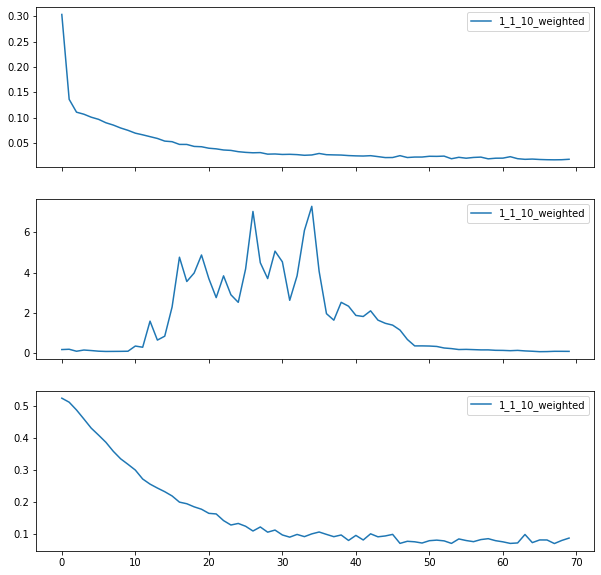

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=False, sharex=True)

epoch_loss = np.array(attention_model.epoch_loss)
epoch_loss_names = [
    ['valid_x_wasserstein_loss', 'fake_x_wasserstein_loss', 'partial_gp_loss_x', '1_1_10_weighted'],
    ['valid_z_wasserstein_loss', 'fake_z_wasserstein_loss', 'partial_gp_loss_z', '1_1_10_weighted'],
    ['fake_gen_x_wasserstein_loss', 'fake_gen_z_wasserstein_loss', 'mse', '1_1_10_weighted'],
]

index = [i for i in range(attention_model.epochs)]

for i in range(3):
    model_losses = epoch_loss[:, i, :]

    # for j, loss in enumerate(model_losses.T):
    #     print(loss)
    axs[i].plot(index, model_losses.T[-1], label=epoch_loss_names[i][-1])
    axs[i].legend()
    

In [49]:
model = AttentionTadGAN(
    input_shape=X_train[0].shape, 
    target_shape=y_train[0].shape,
    attention=False
)
model.fit(X_train, y_train)

Epoch: 1/70, [Dx loss: [-0.97692305 -4.480772    0.14532895  0.33585197]] [Dz loss: [ 5.9210534  -0.05970786  4.6082907   0.13724706]] [G loss: [ 0.7611186  -0.11355221 -3.649291    0.45239615]]
Epoch: 2/70, [Dx loss: [-5.619371   -7.893695    1.3115933   0.09627297]] [Dz loss: [ 2.711645   -0.17675896  1.1434325   0.17449717]] [G loss: [ 4.461532   -1.291007    4.1867023   0.15658368]]
Epoch: 3/70, [Dx loss: [-1.1734436  -6.585193    5.1575313   0.02542189]] [Dz loss: [-12.81835     -0.24643609 -14.116181     0.15442671]] [G loss: [20.221766   -4.9053917  23.776352    0.13508081]]
Epoch: 4/70, [Dx loss: [-0.84344155 -5.356876    3.8363082   0.06771263]] [Dz loss: [ 3.0131874  -0.3311542   2.421659    0.09226827]] [G loss: [ 6.6221957  -3.1044245   8.123588    0.16030322]]
Epoch: 5/70, [Dx loss: [-3.2368522  -1.4793124  -2.1440585   0.03865186]] [Dz loss: [16.102694   -0.36636335 15.140729    0.13283257]] [G loss: [-3.9968338   1.8557783  -7.6536613   0.18010493]]
Epoch: 6/70, [Dx loss

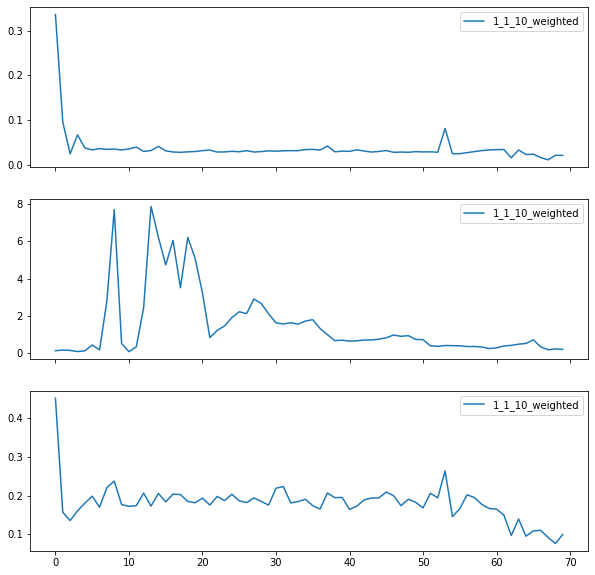

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=False, sharex=True)

epoch_loss = np.array(model.epoch_loss)
epoch_loss_names = [
    ['valid_x_wasserstein_loss', 'fake_x_wasserstein_loss', 'partial_gp_loss_x', '1_1_10_weighted'],
    ['valid_z_wasserstein_loss', 'fake_z_wasserstein_loss', 'partial_gp_loss_z', '1_1_10_weighted'],
    ['fake_gen_x_wasserstein_loss', 'fake_gen_z_wasserstein_loss', 'mse', '1_1_10_weighted'],
]

index = [i for i in range(model.epochs)]

for i in range(3):
    model_losses = epoch_loss[:, i, :]

    # for j, loss in enumerate(model_losses.T):
    #     print(loss)
    axs[i].plot(index, model_losses.T[-1], label=epoch_loss_names[i][j])
    axs[i].legend()

In [15]:
def calculate_anomalies(y_test, y_hat, critic, index_test):
    params = {"rec_error_type": "dtw", "comb": "mult"}

    primitive = load_primitive("orion.primitives.tadgan.score_anomalies", 
                               arguments=params)
    errors, true_index, true, predictions = primitive.produce(y=y_test, y_hat=y_hat, critic=critic, index=index_test)
    
    params = {
    "window_size_portion": 0.33, 
    "window_step_size_portion": 0.1,
    "fixed_threshold": True
    }

    primitive = load_primitive("orion.primitives.timeseries_anomalies.find_anomalies", 
                               arguments=params)
    predicted_anomalies = primitive.produce(errors=errors, index=true_index)
    predicted_anomalies = [(int(anomaly[0]), int(anomaly[1])) for anomaly in predicted_anomalies]
    return predicted_anomalies
    

In [60]:
# computes an array of anomaly scores based on a combination of reconstruction error and critic output
params = {"rec_error_type": "dtw", "comb": "mult"}

primitive = load_primitive("orion.primitives.tadgan.score_anomalies", 
                           arguments=params)
errors, true_index, true, predictions = primitive.produce(y=y_test, y_hat=y_hat, critic=critic, index=index_test)

errors.shape, true_index.shape

((2276,), (2177,))

In [61]:
# extracts anomalies from sequences of errors following the approach
params = {
    "window_size_portion": 0.33, 
    "window_step_size_portion": 0.1,
    "fixed_threshold": True
}

primitive = load_primitive("orion.primitives.timeseries_anomalies.find_anomalies", 
                           arguments=params)
e = primitive.produce(errors=errors, index=true_index)

e.shape

(1, 3)

In [62]:
predicted_anomalies = [(int(i[0]), int(i[1])) for i in e]
start, end = index_test[0], index_test[-1]
contextual_f1_score(anomalies, predicted_anomalies, start=start, end=end, weighted=True)

0.0903765690376569

In [63]:
0.07401696222050887
0.09674728940783987

0.09674728940783987

In [88]:
predicted_anomalies

[(1150, 1207)]

In [89]:
print(anomalies)

  source  name signal  start   end
0   NASA  SMAP    M-2   1110  2250
